**Imports**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
import warnings
warnings.filterwarnings("ignore")

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Pulling data from google drive**

In [2]:
data = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11], index_col=[0], parse_dates=[0])
data.head()

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [3]:
data = data.reset_index().rename(columns = {'timestamp':'ds'})
data = data.rename(columns={data.columns[1]:'y'})
data.head()

,ds,y
0,2018-01-01 05:00:00,0.660
1,2018-01-01 06:00:00,0.660
2,2018-01-01 07:00:00,0.615
3,2018-01-01 08:00:00,0.570
4,2018-01-01 09:00:00,0.570


In [4]:
data['y'] = np.log(data['y'])
data.head()

,ds,y
0,2018-01-01 05:00:00,-0.415515
1,2018-01-01 06:00:00,-0.415515
2,2018-01-01 07:00:00,-0.486133
3,2018-01-01 08:00:00,-0.562119
4,2018-01-01 09:00:00,-0.562119


DEBUG:cmdstanpy:input tempfile: /tmp/tmpw2xepm6_/xufonnf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw2xepm6_/0ba9c4pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97937', 'data', 'file=/tmp/tmpw2xepm6_/xufonnf7.json', 'init=/tmp/tmpw2xepm6_/0ba9c4pi.json', 'output', 'file=/tmp/tmpw2xepm6_/prophet_modelzfucnsim/prophet_model-20230815171300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


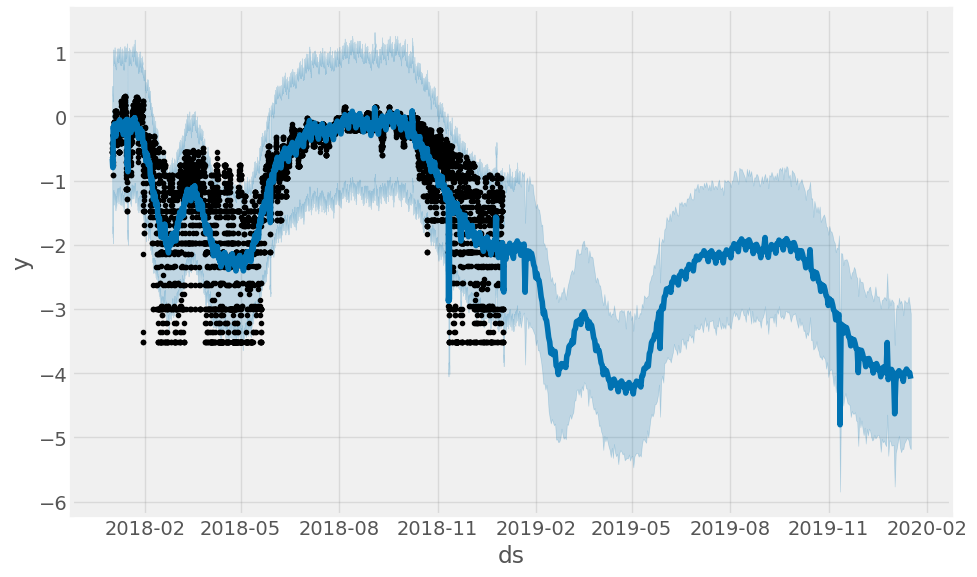

In [5]:
m = Prophet(changepoint_prior_scale=0.011,yearly_seasonality=True,interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(data)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)

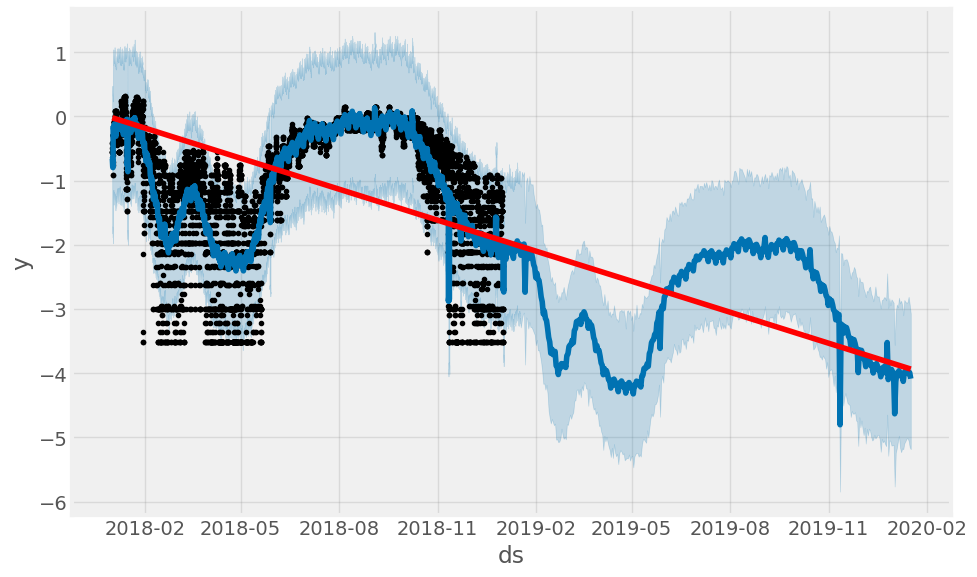

In [6]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [7]:
df = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11], index_col=[0], parse_dates=[0])
df.head()

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [8]:
df = df.rename(columns={df.columns[0]:'y'})
df.head()

,y
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570


In [9]:
df['y'] = np.log(df['y'])
df.head()

,y
timestamp,
2018-01-01 05:00:00,-0.415515
2018-01-01 06:00:00,-0.415515
2018-01-01 07:00:00,-0.486133
2018-01-01 08:00:00,-0.562119
2018-01-01 09:00:00,-0.562119


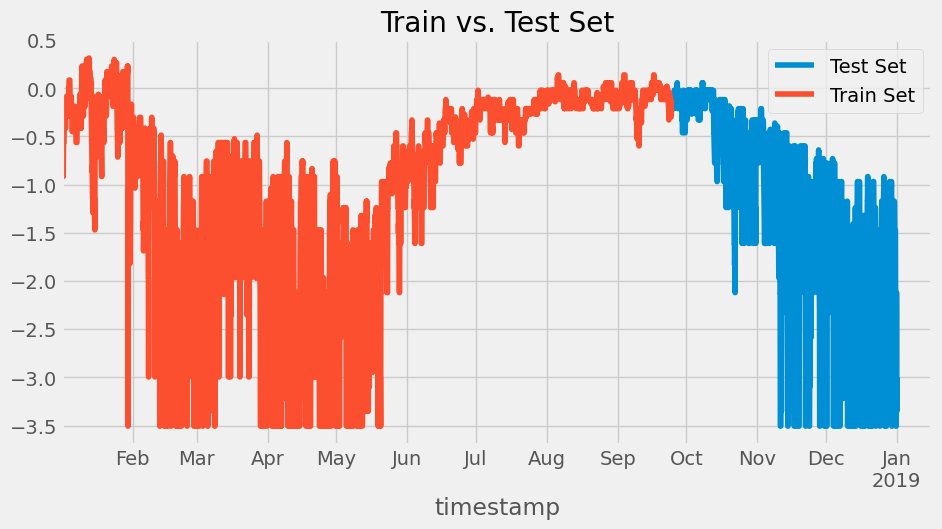

In [10]:
# calculate the split based on percentage
total_rows = len(df)
split_index = int(total_rows * 0.7)  # 70% of the data
split_date = df.index[split_index]

#split_date = 2018-01-01 # enter data manually

train = df.loc[df.index <= split_date].copy()
test = df.loc[df.index > split_date].copy()

test.rename(columns = {'y': 'Test Set'}).join(train.rename(columns = {'y': 'Train Set'}), how = 'outer')\
.plot(figsize = (10,5), title = 'Train vs. Test Set')
plt.show()

In [11]:
train_data = train.reset_index().rename(columns = {'timestamp':'ds'})
test_data = test.reset_index().rename(columns = {'timestamp': 'ds'})

In [12]:
train_data.tail()

,ds,y
6387,2018-09-24 08:00:00,-0.210721
6388,2018-09-24 09:00:00,-0.297732
6389,2018-09-24 10:00:00,-0.238892
6390,2018-09-24 11:00:00,-0.162519
6391,2018-09-24 12:00:00,-0.116534


In [13]:
test_data.head()

,ds,y
0,2018-09-24 13:00:00,-0.116534
1,2018-09-24 14:00:00,-0.116534
2,2018-09-24 15:00:00,-0.116534
3,2018-09-24 16:00:00,-0.116534
4,2018-09-24 17:00:00,-0.116534


In [14]:
m = Prophet(changepoint_prior_scale=0.011,yearly_seasonality=True,interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(train_data)
test_forecast = m.predict(test_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw2xepm6_/3z2zt6rw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw2xepm6_/yuvtholw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79221', 'data', 'file=/tmp/tmpw2xepm6_/3z2zt6rw.json', 'init=/tmp/tmpw2xepm6_/yuvtholw.json', 'output', 'file=/tmp/tmpw2xepm6_/prophet_modelx276we6m/prophet_model-20230815171313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-09-24 13:00:00,-0.685289,-1.163141,0.869661,-0.685289,-0.685289,0.0,0.0,0.0,0.0,...,0.047815,0.047815,0.047815,0.547906,0.547906,0.547906,0.0,0.0,0.0,-0.125311
1,2018-09-24 14:00:00,-0.685258,-1.185165,0.828915,-0.685258,-0.685258,0.0,0.0,0.0,0.0,...,0.035179,0.035179,0.035179,0.547426,0.547426,0.547426,0.0,0.0,0.0,-0.178746
2,2018-09-24 15:00:00,-0.685227,-1.312788,0.803213,-0.685227,-0.685227,0.0,0.0,0.0,0.0,...,0.022710,0.022710,0.022710,0.546945,0.546945,0.546945,0.0,0.0,0.0,-0.231844
3,2018-09-24 16:00:00,-0.685195,-1.230075,0.781906,-0.685195,-0.685195,0.0,0.0,0.0,0.0,...,0.010511,0.010511,0.010511,0.546464,0.546464,0.546464,0.0,0.0,0.0,-0.275594
4,2018-09-24 17:00:00,-0.685164,-1.370637,0.647092,-0.685164,-0.685164,0.0,0.0,0.0,0.0,...,-0.001324,-0.001324,-0.001324,0.545984,0.545984,0.545984,0.0,0.0,0.0,-0.301634


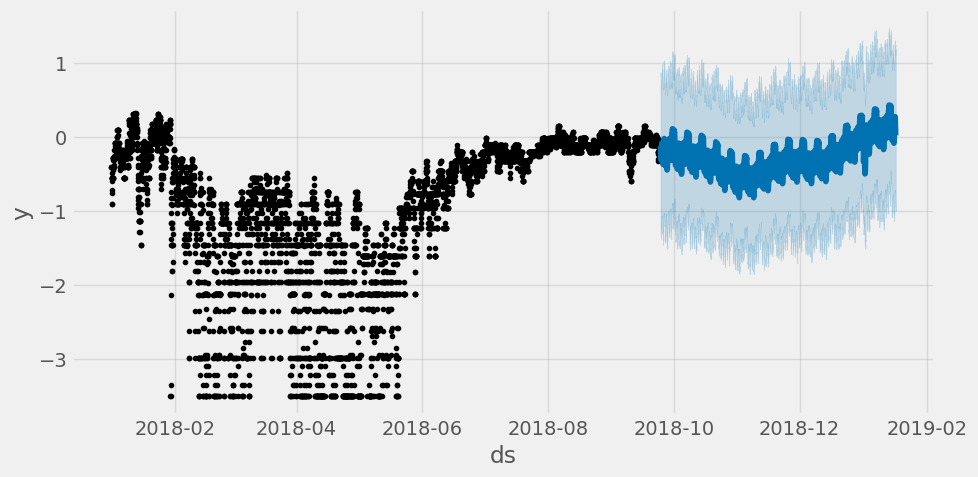

In [16]:
fig, ax = plt.subplots(figsize = (10,5))
fig = m.plot(test_forecast, ax = ax)
ax.set_title = ('Forecast')
plt.show()

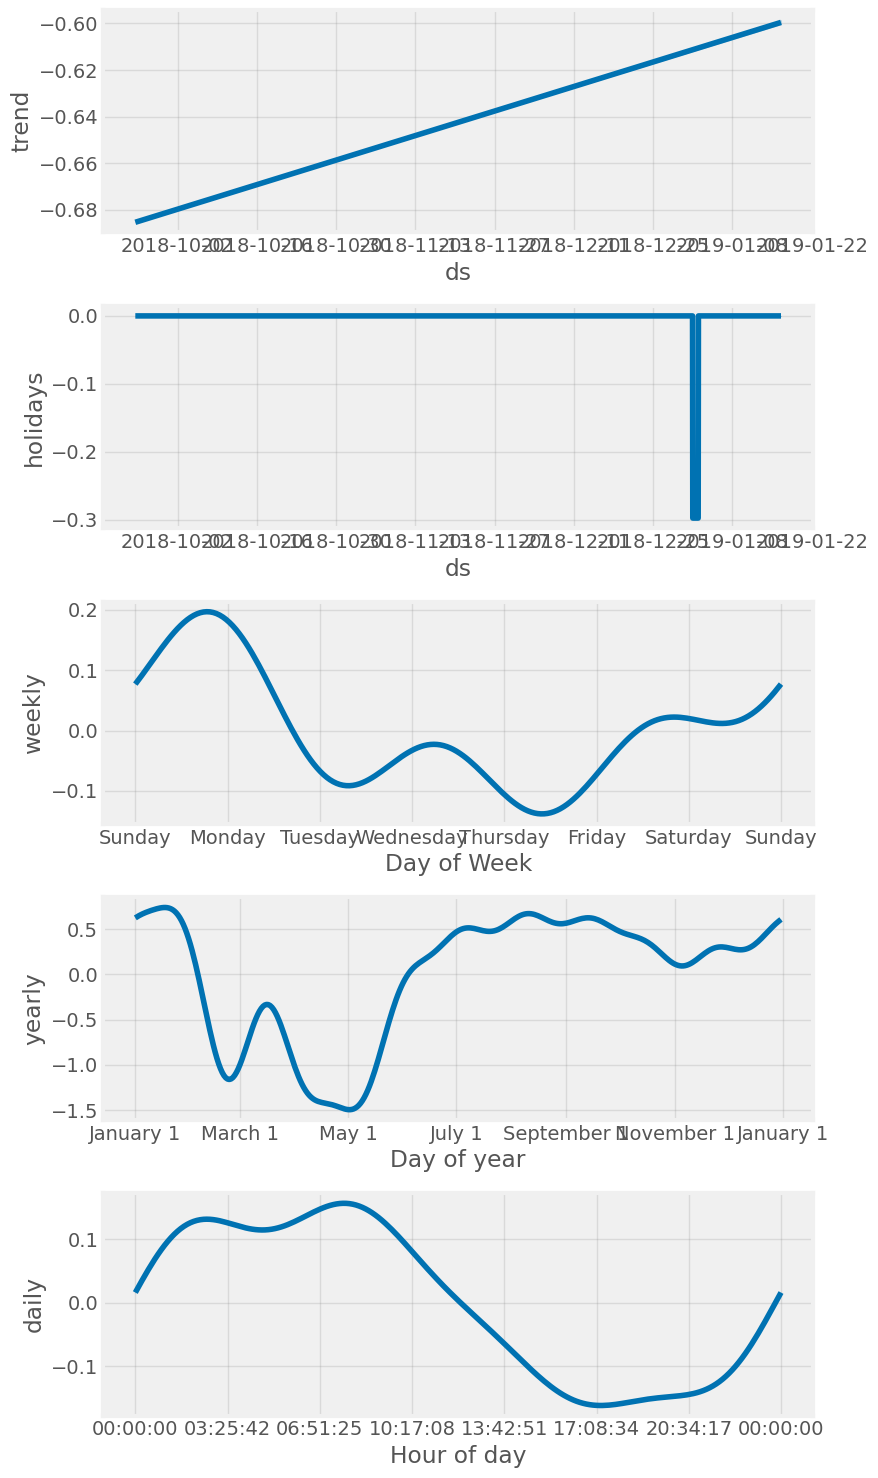

In [17]:
fig = m.plot_components(test_forecast)
plt.show()

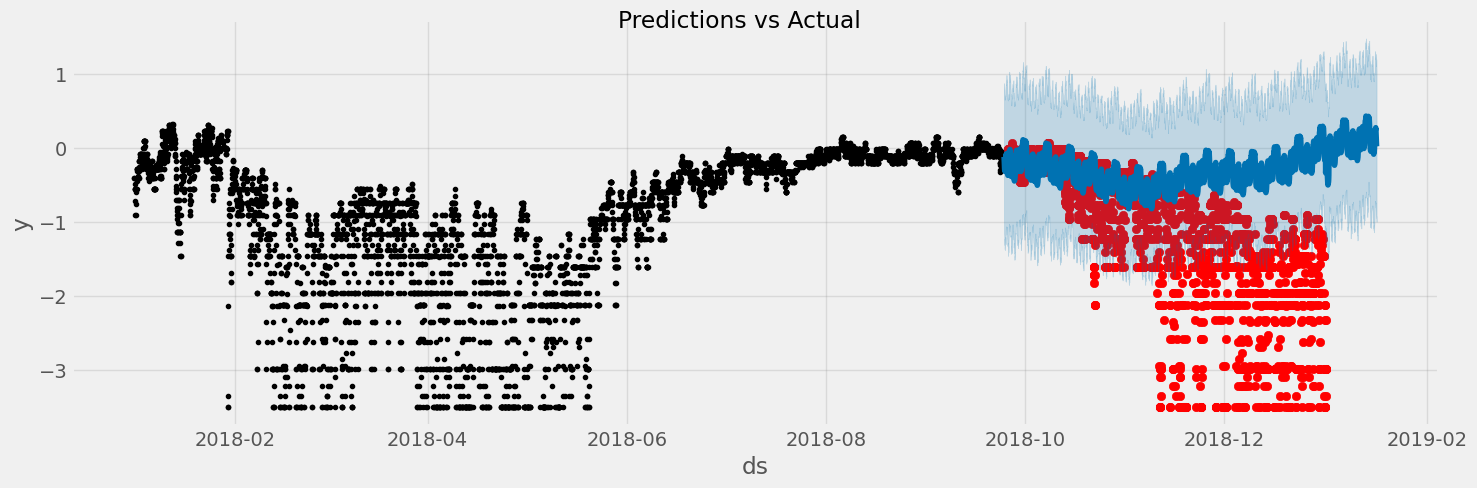

In [18]:
fig, ax = plt.subplots(figsize = (15,5))
ax.scatter(test.index, test['y'], color = 'r')
fig = m.plot(test_forecast, ax=ax)
plot = plt.suptitle('Predictions vs Actual')

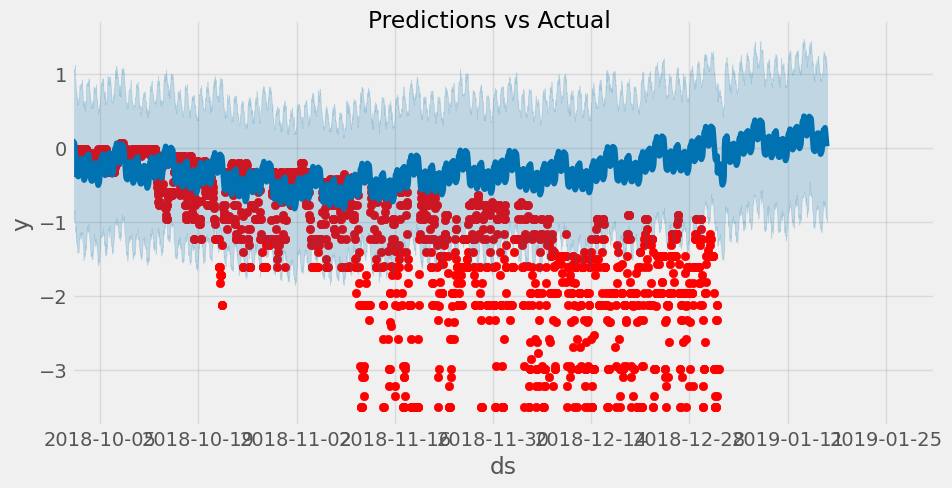

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test.index, test['y'], color='r')
fig = m.plot(test_forecast, ax=ax)
ax.set_xlim(pd.Timestamp('2018-10-01'), pd.Timestamp('2019-02-01'))
plot = plt.suptitle('Predictions vs Actual')

In [173]:
data = pd.read_csv('/content/drive/MyDrive/394_points.csv', usecols=[0,11])
data.head()

,timestamp,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
0,2018-01-01 05:00:00,0.660
1,2018-01-01 06:00:00,0.660
2,2018-01-01 07:00:00,0.615
3,2018-01-01 08:00:00,0.570
4,2018-01-01 09:00:00,0.570


In [174]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   timestamp                                               8760 non-null   object 
 1   House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)  8760 non-null   float64
dtypes: float64(1), object(1)
memory usage: 205.3+ KB


In [175]:
data = data.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('timestamp')
data = data.asfreq('1H')
data = data.sort_index()
data.head(2)

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.66
2018-01-01 06:00:00,0.66


In [176]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

True

In [177]:
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


In [178]:
data.asfreq(freq='1H', fill_value=np.nan)

,House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)
timestamp,
2018-01-01 05:00:00,0.660
2018-01-01 06:00:00,0.660
2018-01-01 07:00:00,0.615
2018-01-01 08:00:00,0.570
2018-01-01 09:00:00,0.570
...,...
2019-01-01 00:00:00,0.035
2019-01-01 01:00:00,0.050
2019-01-01 02:00:00,0.050


In [179]:
total_rows = len(data)
train_percent = 0.7
validation_percent = 0.15

train_index = int(total_rows * train_percent)
validation_index = train_index + int(total_rows * validation_percent)

train_date = data.index[train_index]
validation_date = data.index[validation_index]

train = data.loc[data.index <= train_date].copy()
validation = data.loc[(data.index > train_date) & (data.index <= validation_date)].copy()
test = data.loc[data.index > validation_date].copy()

In [180]:
print(f"Train dates      : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Validation dates : {validation.index.min()} --- {validation.index.max()}  (n={len(validation)})")
print(f"Test dates       : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Train dates      : 2018-01-01 05:00:00 --- 2018-09-13 17:00:00  (n=6133)
Validation dates : 2018-09-13 18:00:00 --- 2018-11-07 11:00:00  (n=1314)
Test dates       : 2018-11-07 12:00:00 --- 2019-01-01 04:00:00  (n=1313)


In [181]:
col = 'House Plant Condenser Water Pump 20 Cwp20kW (Unit: kW)'

In [169]:
max = pd.to_datetime(validation.index.max())
max

Timestamp('2018-11-20 13:00:00', freq='H')

In [182]:
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data.loc[:validation.index.max(), col])
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2018-01-01 05:00:00'), Timestamp('2018-11-07 11:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-08-15 20:37:56 
Last fit date: 2023-08-15 20:37:56 
Skforecast version: 0.9.1 
Python version: 3.10.12 
Forecaster id: None 

In [183]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data[col],
                          steps              = 24,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data.loc[:validation.index.max()]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True,
                          show_progress      = True
                    )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 7447
Number of observations used for backtesting: 1313
    Number of folds: 55
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 17 observations.

Fold: 0
    Training:   2018-01-01 05:00:00 -- 2018-11-07 11:00:00  (n=7447)
    Validation: 2018-11-07 12:00:00 -- 2018-11-08 11:00:00  (n=24)
Fold: 1
    Training:   2018-01-01 05:00:00 -- 2018-11-07 11:00:00  (n=7447)
    Validation: 2018-11-08 12:00:00 -- 2018-11-09 11:00:00  (n=24)
Fold: 2
    Training:   2018-01-01 05:00:00 -- 2018-11-07 11:00:00  (n=7447)
    Validation: 2018-11-09 12:00:00 -- 2018-11-10 11:00:00  (n=24)
Fold: 3
    Training:   2018-01-01 05:00:00 -- 2018-11-07 11:00:00  (n=7447)
    Validation: 2018-11-10 12:00:00 -- 2018-11-11 11:00:00  (n=24)
Fold: 4
    Training:   2018-01-01 05:00:00 -- 2018-11-07 11:00

  0%|          | 0/55 [00:00<?, ?it/s]

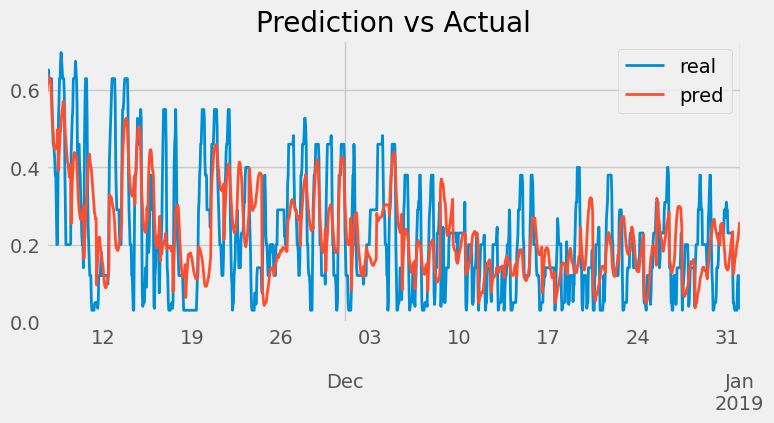

In [184]:
fig, ax = plt.subplots(figsize=(10,15))
data.loc[predictions.index, col].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Actual')
ax.legend();

In [185]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 0.10544320834030045


In [186]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24, # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )

# Lags used as predictors
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:validation.index.max(), col],
                   steps              = 24,
                   metric             = 'mean_absolute_error',
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   initial_train_size = len(data[:train.index.max()]),
                   refit              = False,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False,
                   show_progress      = True
               )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 0.001}
  Backtesting metric: 0.09054458364301486



In [187]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_absolute_error,alpha
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},0.090545,0.001000
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.007742636826811269},0.090545,0.007743
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.05994842503189409},0.090551,0.059948
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.46415888336127775},0.090594,0.464159
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 3.593813663804626},0.090944,3.593814
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 27.825594022071257},0.093707,27.825594
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},0.093732,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.007742636826811269},0.093732,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.05994842503189409},0.093737,0.059948
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},0.093777,0.464159


In [188]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=0.001, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2018-01-01 05:00:00'), Timestamp('2018-11-07 11:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-08-15 20:42:59 
Last fit date: 2023-08-15 20:43:12 
Skforecast version: 0.9.1 
Python version: 3.10.12 
Forecaster id: None 

  0%|          | 0/55 [00:00<?, ?it/s]

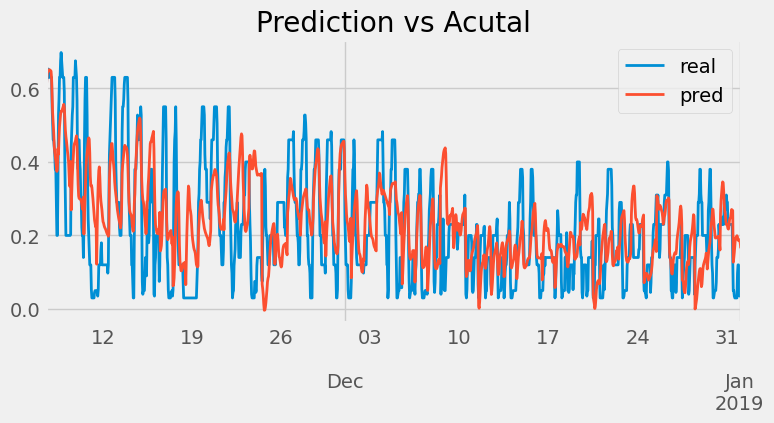

In [189]:
# Backtest final model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data[col],
                          steps              = 24,
                          metric             = mean_absolute_error,
                          initial_train_size = len(data[:validation.index.max()]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False,
                          show_progress      = True
                      )

fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, col].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Acutal')
ax.legend();

In [190]:
# Backtest error
# ==============================================================================
print(f'Backtest error: {metric}')

Backtest error: 0.10434708289237599
